## Proyecto Final

### Integrantes
### Oziel Imanol Lemus Montelongo
### Daniel Isaí Saldaña Rocha
### Guillermo Gonzalo Veyro Ramos

## Modelo Estrella

In [5]:
# Importación de las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt

# Carga de los datos desde un archivo CSV
data = pd.read_csv('./vgsales.csv')

# Agrupación de datos por 'Genre' y suma de 'Global_Sales', ordenando de mayor a menor
genre_sales = data.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)

# Agrupación de datos por 'Platform' y suma de 'Global_Sales', ordenando de mayor a menor
platform_sales = data.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False)

# Agrupación de datos por 'Publisher' y suma de 'Global_Sales', ordenando de mayor a menor
publisher_sales = data.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False)

# Selección de los 5 géneros con mayores ventas globales
top_genres = genre_sales.head(5)

# Selección de las 5 plataformas con mayores ventas globales
top_platforms = platform_sales.head(5)

# Selección de las 5 publicadoras con mayores ventas globales
top_publishers = publisher_sales.head(5)

# Impresión de los resultados obtenidos
print("Top 5 Géneros por Ventas Globales:")
print(top_genres)
print("\nTop 5 Plataformas por Ventas Globales:")
print(top_platforms)
print("\nTop 5 Publicadoras por Ventas Globales:")
print(top_publishers)


Top 5 Géneros por Ventas Globales:
Genre
Action          563.00
Shooter         487.12
Platform        433.80
Role-Playing    398.94
Sports          395.72
Name: Global_Sales, dtype: float64

Top 5 Plataformas por Ventas Globales:
Platform
Wii     444.46
X360    391.59
PS2     390.45
PS3     333.88
DS      312.75
Name: Global_Sales, dtype: float64

Top 5 Publicadoras por Ventas Globales:
Publisher
Nintendo                       1313.27
Activision                      304.95
Electronic Arts                 291.30
Sony Computer Entertainment     275.49
Take-Two Interactive            191.24
Name: Global_Sales, dtype: float64


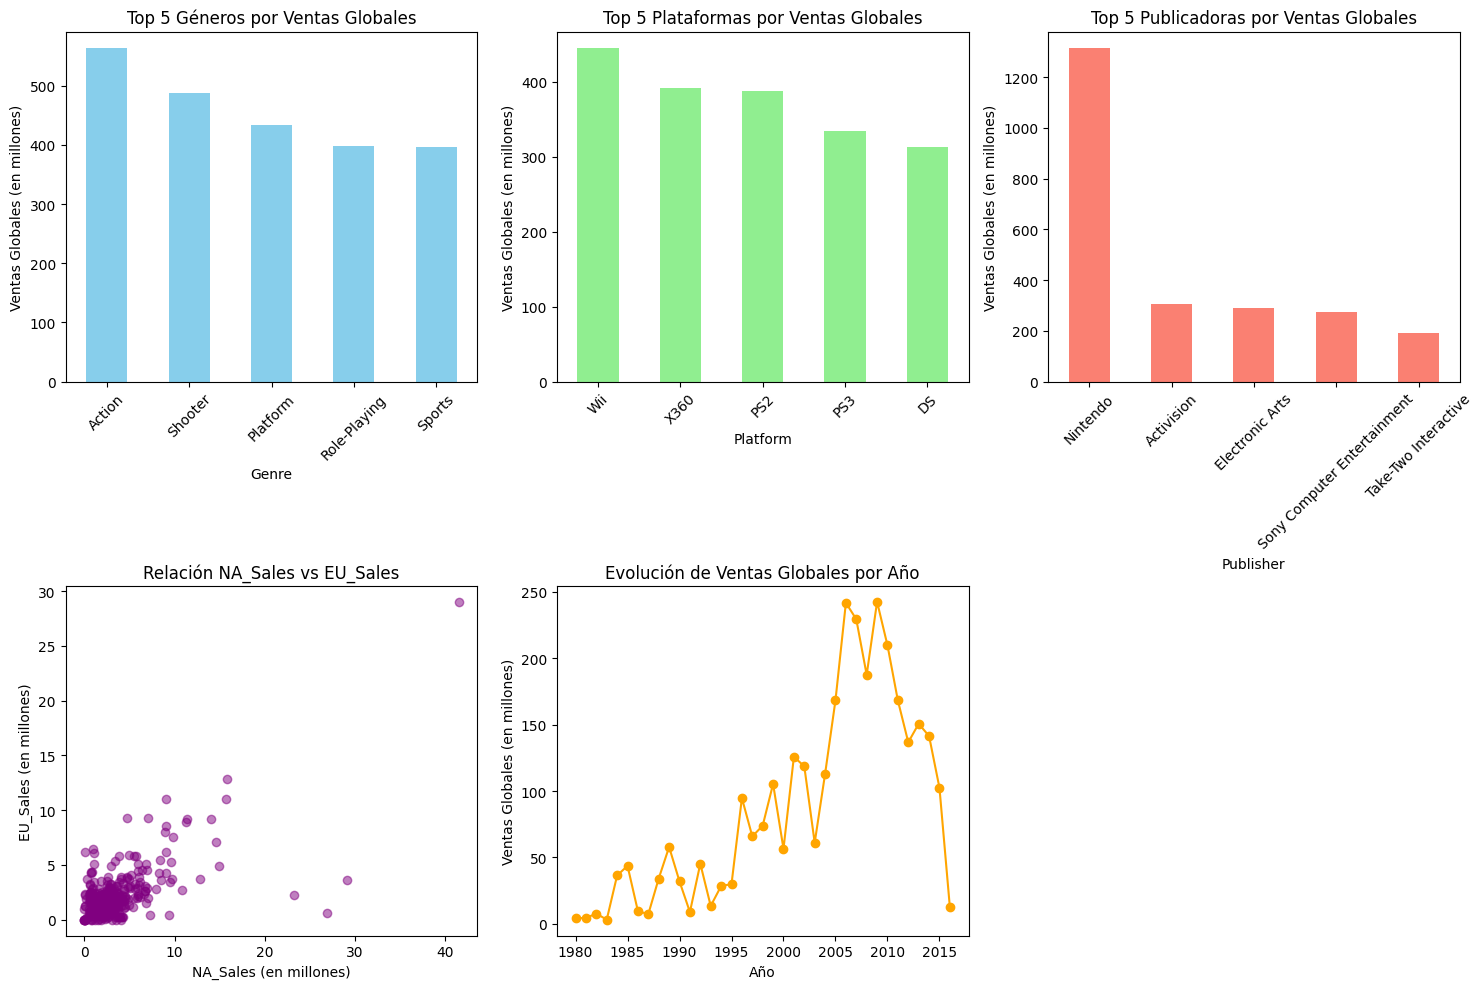

In [2]:
# ---------------------------
# Limpieza de datos
# ---------------------------

# Eliminación de filas duplicadas en el DataFrame
data = data.drop_duplicates()

# Manejo de valores faltantes en la columna 'Year' reemplazándolos por la mediana
data['Year'] = data['Year'].fillna(data['Year'].median()) 

# Eliminación de filas donde 'Publisher' es nulo
data = data.dropna(subset=['Publisher'])

# Conversión de la columna 'Year' a tipo entero
data['Year'] = data['Year'].astype(int)

# ---------------------------
# Gráficos exploratorios
# ---------------------------

# Configuración del tamaño de la figura para los gráficos
plt.figure(figsize=(15, 10))

# -----------------------------------
# Gráfico 1: Top 5 Géneros por Ventas Globales
# -----------------------------------
genre_sales = data.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).head(5)
plt.subplot(2, 3, 1)  # Define la posición del subplot (fila 1, columna 3, posición 1)
genre_sales.plot(kind='bar', color='skyblue')  # Crea un gráfico de barras
plt.title('Top 5 Géneros por Ventas Globales')  # Título del gráfico
plt.ylabel('Ventas Globales (en millones)')  # Etiqueta del eje Y
plt.xticks(rotation=45)  # Rotación de las etiquetas del eje X para mejor legibilidad

# -----------------------------------
# Gráfico 2: Top 5 Plataformas por Ventas Globales
# -----------------------------------
platform_sales = data.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).head(5)
plt.subplot(2, 3, 2)  # Posición del subplot (fila 1, columna 3, posición 2)
platform_sales.plot(kind='bar', color='lightgreen')  # Gráfico de barras
plt.title('Top 5 Plataformas por Ventas Globales')  # Título del gráfico
plt.ylabel('Ventas Globales (en millones)')  # Etiqueta del eje Y
plt.xticks(rotation=45)  # Rotación de etiquetas del eje X

# -----------------------------------
# Gráfico 3: Top 5 Publicadoras por Ventas Globales
# -----------------------------------
publisher_sales = data.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False).head(5)
plt.subplot(2, 3, 3)  # Posición del subplot (fila 1, columna 3, posición 3)
publisher_sales.plot(kind='bar', color='salmon')  # Gráfico de barras
plt.title('Top 5 Publicadoras por Ventas Globales')  # Título del gráfico
plt.ylabel('Ventas Globales (en millones)')  # Etiqueta del eje Y
plt.xticks(rotation=45)  # Rotación de etiquetas del eje X

# -----------------------------------
# Gráfico 4: Relación entre NA_Sales y EU_Sales
# -----------------------------------
plt.subplot(2, 3, 4)  # Posición del subplot (fila 2, columna 3, posición 4)
plt.scatter(data['NA_Sales'], data['EU_Sales'], alpha=0.5, color='purple')  # Gráfico de dispersión
plt.title('Relación NA_Sales vs EU_Sales')  # Título del gráfico
plt.xlabel('NA_Sales (en millones)')  # Etiqueta del eje X
plt.ylabel('EU_Sales (en millones)')  # Etiqueta del eje Y

# -----------------------------------
# Gráfico 5: Evolución de Ventas Globales por Año
# -----------------------------------
sales_by_year = data.groupby('Year')['Global_Sales'].sum()
plt.subplot(2, 3, 5)  # Posición del subplot (fila 2, columna 3, posición 5)
sales_by_year.plot(kind='line', color='orange', marker='o')  # Gráfico de línea con marcadores
plt.title('Evolución de Ventas Globales por Año')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje X
plt.ylabel('Ventas Globales (en millones)')  # Etiqueta del eje Y

# Ajuste del layout para evitar solapamientos
plt.tight_layout()

# Mostrar todos los gráficos
plt.show()


In [3]:
# -----------------------------------
# Conexión y manipulación de bases de datos PostgreSQL
# -----------------------------------

import psycopg2

# ---------------------------
# Manejo de valores faltantes y conversión de tipos (repetido)
# ---------------------------

# Estas líneas ya fueron ejecutadas anteriormente, pero se repiten aquí probablemente por error
data['Year'] = data['Year'].fillna(data['Year'].median())  
data = data.dropna(subset=['Publisher'])
data['Year'] = data['Year'].astype(int)

# Separación de columnas cuantitativas y cualitativas
cuantitativas = data.select_dtypes(include=['int64', 'float64'])  # Selecciona columnas de tipo numérico
cualitativas = data.select_dtypes(include=['object'])  # Selecciona columnas de tipo objeto (cualitativas)

# ---------------------------
# Conexión a la base de datos PostgreSQL
# ---------------------------

try:
    # Establece la conexión con la base de datos PostgreSQL
    conn = psycopg2.connect(
        user="postgres",
        password="root",
        host="localhost",
        port="5432",
        database="DbVideogamesSales"
    )
    print("Conexión exitosa a la base de datos")
except Exception as e:
    # Captura y muestra cualquier error de conexión
    print(f"Error al conectar a la base de datos: {e}")
    exit()

# Crear un cursor para interactuar con la base de datos
cur = conn.cursor()

def crear_tabla(df, nombre_tabla, cur, conn):
    """
    Crea una tabla en la base de datos PostgreSQL a partir de un DataFrame.
    
    Parámetros:
    - df: DataFrame de pandas con los datos.
    - nombre_tabla: Nombre de la tabla a crear.
    - cur: Cursor de la base de datos.
    - conn: Conexión a la base de datos.
    """
    # Mapeo de tipos de datos de pandas a PostgreSQL
    dtype_mapping = {
        'object': 'TEXT',
        'int64': 'INT',
        'float64': 'FLOAT',
        'bool': 'BOOLEAN'
    }

    columns = []
    # Construcción de la definición de columnas para la tabla SQL
    for col, dtype in zip(df.columns, df.dtypes):
        pg_type = dtype_mapping.get(str(dtype), 'TEXT')  # Obtiene el tipo PostgreSQL correspondiente
        columns.append(f"{col} {pg_type}")

    columns_sql = ", ".join(columns)  # Une las definiciones de columnas separadas por comas
    SQLQuery = f"CREATE TABLE IF NOT EXISTS {nombre_tabla} ({columns_sql});"  # Consulta SQL para crear la tabla

    try:
        cur.execute(SQLQuery)  # Ejecuta la consulta SQL
        conn.commit()  # Confirma los cambios en la base de datos
        print(f"Tabla '{nombre_tabla}' creada correctamente.")
    except Exception as e:
        # Manejo de errores durante la creación de la tabla
        print(f"Error al crear la tabla '{nombre_tabla}': {e}")

def insertar_datos(df, nombre_tabla, cur, conn):
    """
    Inserta datos en una tabla de PostgreSQL a partir de un DataFrame.
    
    Parámetros:
    - df: DataFrame de pandas con los datos.
    - nombre_tabla: Nombre de la tabla donde insertar los datos.
    - cur: Cursor de la base de datos.
    - conn: Conexión a la base de datos.
    """
    df = df.where(pd.notnull(df), None)  # Reemplaza valores NaN por None para compatibilidad con SQL
    columns = df.columns.tolist()  # Lista de nombres de columnas
    values_template = ", ".join(["%s"] * len(columns))  # Plantilla para valores a insertar
    insert_query = f"INSERT INTO {nombre_tabla} ({', '.join(columns)}) VALUES ({values_template}) ON CONFLICT DO NOTHING;"  # Consulta SQL para insertar datos

    values = [tuple(row) for row in df.to_numpy()]  # Convierte el DataFrame a una lista de tuplas

    try:
        cur.executemany(insert_query, values)  # Inserta múltiples filas a la vez
        conn.commit()  # Confirma los cambios
        print(f"Datos insertados correctamente en la tabla '{nombre_tabla}'.")
    except Exception as e:
        # Revertir cambios en caso de error
        conn.rollback()
        print(f"Error al insertar datos en la tabla '{nombre_tabla}': {e}")

# ---------------------------
# Creación e inserción de datos en tablas cuantitativas y cualitativas
# ---------------------------

# Crear tabla para datos cuantitativos
crear_tabla(cuantitativas, 'cuantitativas', cur, conn)

# Crear tabla para datos cualitativos
crear_tabla(cualitativas, 'cualitativas', cur, conn)

# Insertar datos en la tabla 'cuantitativas'
insertar_datos(cuantitativas, 'cuantitativas', cur, conn)

# Insertar datos en la tabla 'cualitativas'
insertar_datos(cualitativas, 'cualitativas', cur, conn)

# ---------------------------
# Conexión a la base de datos del data warehouse
# ---------------------------

dwh_conn = None  # Inicializa la conexión al data warehouse como None

try:
    # Establece la conexión con la base de datos del data warehouse
    dwh_conn = psycopg2.connect(
        user="postgres",
        password="root",
        host="localhost",
        port="5432",
        database="dwhissc712"
    )
    print("Conexión exitosa al data warehouse")
except Exception as e:
    # Captura y muestra cualquier error de conexión
    print(f"Error al conectar al data warehouse: {e}")
    exit()

# Crear un cursor para el data warehouse
dwh_cur = dwh_conn.cursor()

# ---------------------------
# Creación de dimensiones y tabla de hechos en el data warehouse
# ---------------------------

# ---------------------------
# Dimensión: Platform
# ---------------------------

# Selecciona plataformas únicas y resetea el índice
platform_dimension = data[['Platform']].drop_duplicates().reset_index(drop=True)

# Asigna un ID único a cada plataforma
platform_dimension['PlatformID'] = platform_dimension.index + 1

# Crear tabla 'dim_platform' en el data warehouse
crear_tabla(platform_dimension, 'dim_platform', dwh_cur, dwh_conn)

# Insertar datos en la tabla 'dim_platform'
insertar_datos(platform_dimension, 'dim_platform', dwh_cur, dwh_conn)

# ---------------------------
# Dimensión: Genre
# ---------------------------

# Selecciona géneros únicos y resetea el índice
genre_dimension = data[['Genre']].drop_duplicates().reset_index(drop=True)

# Asigna un ID único a cada género
genre_dimension['GenreID'] = genre_dimension.index + 1

# Crear tabla 'dim_genre' en el data warehouse
crear_tabla(genre_dimension, 'dim_genre', dwh_cur, dwh_conn)

# Insertar datos en la tabla 'dim_genre'
insertar_datos(genre_dimension, 'dim_genre', dwh_cur, dwh_conn)

# ---------------------------
# Tabla de Hechos: fact_sales
# ---------------------------

# Fusiona los datos con las dimensiones para obtener los IDs correspondientes
fact_table = data.merge(platform_dimension, on='Platform').merge(genre_dimension, on='Genre')

# Selecciona las columnas relevantes para la tabla de hechos
fact_table = fact_table[['PlatformID', 'GenreID', 'Year', 'Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]

# Crear tabla 'fact_sales' en el data warehouse
crear_tabla(fact_table, 'fact_sales', dwh_cur, dwh_conn)

# Insertar datos en la tabla 'fact_sales'
insertar_datos(fact_table, 'fact_sales', dwh_cur, dwh_conn)

# ---------------------------
# Cierre de conexiones a las bases de datos
# ---------------------------

cur.close()        # Cierra el cursor de la base de datos principal
conn.close()       # Cierra la conexión de la base de datos principal
dwh_cur.close()    # Cierra el cursor del data warehouse
dwh_conn.close()   # Cierra la conexión al data warehouse

Conexión exitosa a la base de datos
Tabla 'cuantitativas' creada correctamente.
Tabla 'cualitativas' creada correctamente.
Datos insertados correctamente en la tabla 'cuantitativas'.
Datos insertados correctamente en la tabla 'cualitativas'.
Conexión exitosa al data warehouse
Tabla 'dim_platform' creada correctamente.
Datos insertados correctamente en la tabla 'dim_platform'.
Tabla 'dim_genre' creada correctamente.
Datos insertados correctamente en la tabla 'dim_genre'.
Tabla 'fact_sales' creada correctamente.
Datos insertados correctamente en la tabla 'fact_sales'.


## Conclusión 1er Parcial: 
La aplicación práctica de conceptos fundamentales relacionados con la manipulación de datos, análisis exploratorio, visualización y diseño de sistemas de almacenamiento en bases de datos. A través del uso de herramientas como Python, bibliotecas especializadas (pandas, matplotlib) y bases de datos relacionales (PostgreSQL), se logró procesar, limpiar y analizar un conjunto de datos complejo, obteniendo resultados relevantes para el dominio de estudio.

Se destaca la importancia de realizar una adecuada limpieza y estructuración de los datos antes de proceder con cualquier análisis, asegurando así la validez de los resultados obtenidos. La integración de un modelo de data warehouse permitió diseñar un sistema escalable, organizado y óptimo para el análisis multidimensional, alineado con las necesidades de gestión de información en entornos reales.

Finalmente, hay que destacar la relevancia de combinar habilidades técnicas en programación, análisis de datos y diseño de sistemas para abordar problemas complejos, transformando grandes volúmenes de datos en información significativa y útil. Los aprendizajes adquiridos aquí son transferibles a contextos profesionales, subrayando el valor del rigor metodológico y la innovación en proyectos de análisis de datos.

# 2do Parcial
## Analisis de clustering con k-means

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [7]:
# Limita el uso de hilos a uno solo en bibliotecas de cálculo numérico para optimizar recursos.
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

### 	Se seleccionan las columnas relacionadas con las ventas para el análisis (NA_Sales, EU_Sales, JP_Sales, Other_Sales y Global_Sales).
### 	Esto permite centrarse exclusivamente en las métricas de ventas.

In [8]:
# Selecciona las columnas relevantes para realizar el análisis con KMeans.
df_kmeans = data[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]

df_multiLinear = df_kmeans  # Se utiliza específicamente para la sección del 3er parcial.

# Muestra las primeras filas del DataFrame seleccionado para KMeans.
df_kmeans.head()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,41.49,29.02,3.77,8.46,82.74
1,29.08,3.58,6.81,0.77,40.24
2,15.85,12.88,3.79,3.31,35.82
3,15.75,11.01,3.28,2.96,33.00
4,11.27,8.89,10.22,1.00,31.37


### 	Los datos se normalizan utilizando StandardScaler para ajustar las ventas de cada región a una escala uniforme (media = 0 y desviación estándar = 1).
### 	Esto es crucial para que todas las columnas tengan igual influencia en los algoritmos de análisis.

In [9]:
# Crea una instancia de StandardScaler para estandarizar los datos (media = 0, desviación estándar = 1).
scaler = StandardScaler()

# Escala los datos del DataFrame df_kmeans para normalizarlos y facilitar el análisis.
datos_escalados = scaler.fit_transform(df_kmeans)

### 	Se aplica PCA (Análisis de Componentes Principales) para transformar los datos a 5 componentes principales.
### 	Esto reduce la dimensionalidad manteniendo la mayor cantidad posible de variación en los datos.

In [10]:
# Crea una instancia de PCA (Análisis de Componentes Principales) para reducir la dimensionalidad a 5 componentes.
pca = PCA(n_components=5)

# Ajusta el modelo PCA a los datos escalados y transforma los datos originales en sus componentes principales.
componentes_pca = pca.fit_transform(datos_escalados)

### 	Se calcula cuánto de la variación total explican los componentes principales.
### 	Esto ayuda a evaluar la efectividad de la reducción de dimensionalidad.

In [11]:
# Obtiene el porcentaje de variación explicada por cada uno de los componentes principales.
variacion_explicada = pca.explained_variance_ratio_

### 	Se grafican tanto la variación explicada como la acumulada por cada componente.
### 	Esto facilita identificar el número adecuado de componentes principales para análisis futuros.

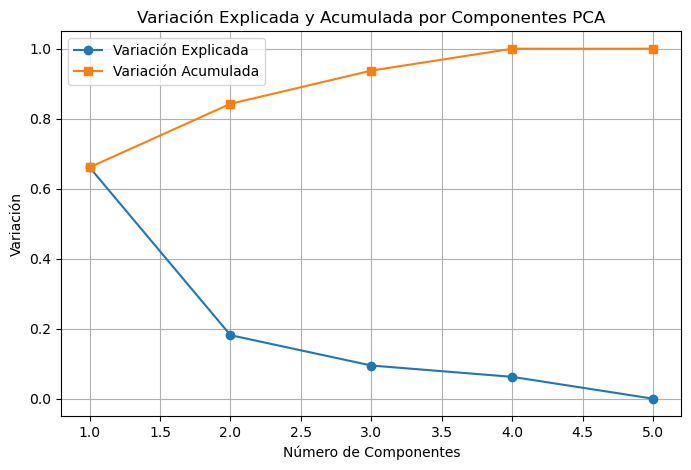

In [12]:
# Calcula la variación acumulada explicada por los componentes principales.
variacion_acumulada = np.cumsum(variacion_explicada)

# Crea una figura para visualizar la variación explicada y acumulada.
plt.figure(figsize=(8, 5))

# Grafica la variación explicada por cada componente principal.
plt.plot(range(1, len(variacion_explicada) + 1), variacion_explicada, marker='o', label='Variación Explicada')

# Grafica la variación acumulada explicada por los componentes.
plt.plot(range(1, len(variacion_acumulada) + 1), variacion_acumulada, marker='s', label='Variación Acumulada')

# Configuración del gráfico: título, leyenda y cuadrícula.
plt.xlabel('Número de Componentes')
plt.ylabel('Variación')
plt.title('Variación Explicada y Acumulada por Componentes PCA')
plt.legend()
plt.grid(True)
plt.show()

### 	Se calcula el WCSS (Within-Cluster Sum of Squares) para diferentes números de clusters.
### 	Un gráfico muestra el método del codo, ayudando a determinar el número óptimo de clusters.

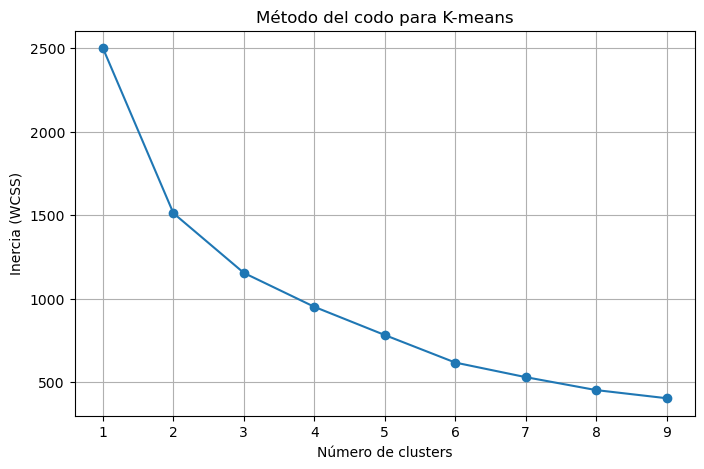

In [13]:
# Calcula el WCSS (Within-Cluster Sum of Squares) para diferentes números de clusters.
wcss = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)  # Configuración del modelo KMeans.
    kmeans.fit(componentes_pca)  # Ajusta el modelo a los datos transformados por PCA.
    wcss.append(kmeans.inertia_)  # Almacena la inercia (WCSS) para el número de clusters actual.

# Visualiza el resultado del método del codo para determinar el número óptimo de clusters.
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Método del codo para K-means')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia (WCSS)')
plt.grid(True)
plt.show()

### 	Se configuran 3 clusters con KMeans y se asigna un cluster a cada punto de datos.
### 	Un gráfico de dispersión visualiza los clusters en el espacio de los dos primeros componentes principales, destacando los centroides.

/var/folders/8y/n92rcsqx2p14tk1dv66z141c0000gn/T/ipykernel_54033/461421515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans['Cluster'] = cluster_kmeans


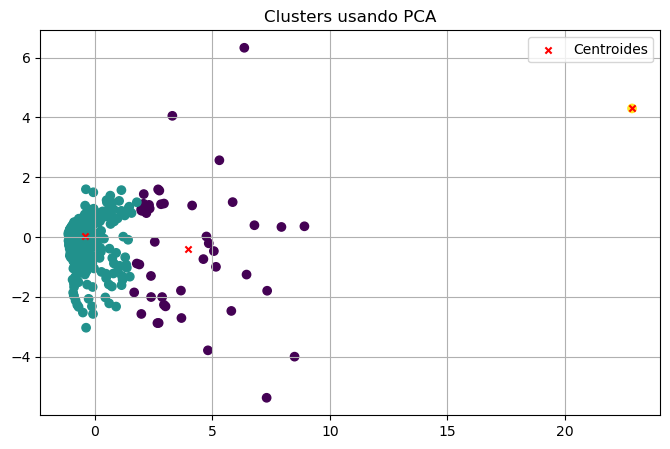

In [15]:
# Configura el modelo KMeans para 3 clusters y ajusta los datos transformados por PCA.
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
cluster_kmeans = kmeans.fit_predict(componentes_pca)

# Asocia los clusters obtenidos al DataFrame original.
df_kmeans['Cluster'] = cluster_kmeans

# Visualiza los clusters en un gráfico de dispersión utilizando los dos primeros componentes principales.
plt.figure(figsize=(8, 5))
plt.scatter(componentes_pca[:, 0], componentes_pca[:, 1], c=df_kmeans['Cluster'], cmap='viridis', marker='o')

# Agrega los centroides calculados por KMeans al gráfico.
centroides = kmeans.cluster_centers_ 
plt.scatter(centroides[:, 0], centroides[:, 1], s=20, c='red', marker='x', label='Centroides')

# Configuración del gráfico: título, leyenda y cuadrícula.
plt.title('Clusters usando PCA')
plt.legend()
plt.grid(True)
plt.show()

## Conclusión 2do Parcial: 
El análisis realizado utiliza técnicas avanzadas como normalización, PCA y KMeans para interpretar las ventas de videojuegos. PCA destaca los factores más significativos, reduciendo la complejidad de los datos mientras que KMeans identifica patrones de agrupamiento entre las ventas regionales y globales. Este enfoque proporciona una comprensión clara y visualmente intuitiva de los datos, útil para tomar decisiones estratégicas basadas en las tendencias identificadas.

## 3er parcial

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split ##Fase de pruebas de entrenamiento
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score #COEFICIENTE DE DETERMINACION
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import Ridge, Lasso, ElasticNet
## EVALUAR METRICAS DE RENDIMIENTO
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [14]:
df_multiLinear

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Cluster
0,41.49,29.02,3.77,8.46,82.74,2
1,29.08,3.58,6.81,0.77,40.24,1
2,15.85,12.88,3.79,3.31,35.82,1
3,15.75,11.01,3.28,2.96,33.00,1
4,11.27,8.89,10.22,1.00,31.37,1
...,...,...,...,...,...,...
495,1.54,1.14,0.00,0.22,2.90,0
496,1.75,0.86,0.00,0.28,2.90,0
497,0.08,1.24,1.13,0.45,2.90,0
498,0.71,1.51,0.06,0.61,2.89,0


#### Single Linear regression

In [15]:
vIndSingle = df_multiLinear['NA_Sales'].values.reshape(-1, 1) 
# -1 ubica el numero de elementos y lo convierte al numero de filas
# el 1 es solo pora indicar que solo se va a usar una columna

vDepSingle = df_multiLinear['Global_Sales'].values

In [16]:
# Creación de variables independientes y dependientes de pruebas y entrenamiento
vInd_entrenamientoSingle, vInd_pruebasSingle, vDep_entrenamientoSingle, vDep_pruebasSingle = train_test_split(vIndSingle, vDepSingle, test_size = 0.2, random_state = 42)

In [17]:
# Asignacion del modelo de regrecion lineal para el modelo simple
modeloSingle = LinearRegression()
modeloSingle.fit(vInd_entrenamientoSingle, vDep_entrenamientoSingle)

LinearRegression()

In [18]:
#Pendiente e Interseccion

pendienteSingle = modeloSingle.coef_[0]
interseccionSingle = modeloSingle.intercept_

print(f"Pendiente (m): {pendienteSingle}")
print(f"intersección (m): {interseccionSingle}")

Pendiente (m): 1.6186902354790034
intersección (m): 1.476765979695931


In [19]:
# Calcular las predicciones
prediccion_entrenamientoSingle = modeloSingle.predict(vInd_entrenamientoSingle)

prediccion_pruebaSingle = modeloSingle.predict(vInd_pruebasSingle)

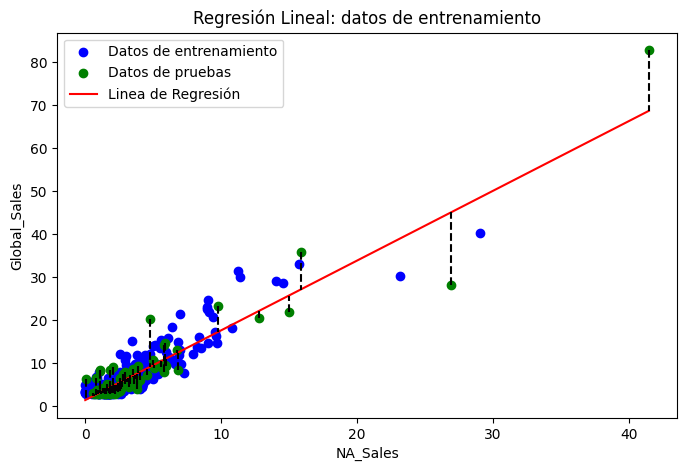

R2 en datos de pruebas: 0.8825319231938941


In [20]:
plt.figure(figsize=(8,5))
# VALORES DE ENTRENAMIENTO
plt.scatter(vInd_entrenamientoSingle, vDep_entrenamientoSingle, label='Datos de entrenamiento', color='blue')
plt.scatter(vInd_pruebasSingle, vDep_pruebasSingle, label='Datos de pruebas', color='green')

# GRAFICAR LINEA DE REGRESION LINEAL SIMPLE
Linea = np.linspace(min(vIndSingle), max(vIndSingle)).reshape(-1,1)
Linea_prediccion = modeloSingle.predict(Linea)
plt.plot(Linea, Linea_prediccion, label='Linea de Regresión', color='Red')

#Marcar error o residuo
for i in range(len(vInd_pruebasSingle)):
    plt.plot([vInd_pruebasSingle[i], vInd_pruebasSingle[i]], [vDep_pruebasSingle[i], prediccion_pruebaSingle[i]], color='black', linestyle='--')

plt.plot()

plt.xlabel('NA_Sales')
plt.ylabel('Global_Sales')
plt.title('Regresión Lineal: datos de entrenamiento')
plt.legend()
plt.show()

# R2 - COEFICIENTE DE DETERMINACIÓN
r2_pruebas =  r2_score(vDep_pruebasSingle, prediccion_pruebaSingle)

print(f"R2 en datos de pruebas: {r2_pruebas}")

#### Multiple Linear regression

In [21]:
#Asignación de variables al modelo multiple
vIndMultiple = df_multiLinear[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]

vDepMultiple  = df_multiLinear['Global_Sales'].values

In [22]:
# Variables contante y vif de datos
vConstante = add_constant(vIndMultiple)
vif_datos = pd.DataFrame()

vif_datos['Nombre Variables'] = vConstante.columns

vif_datos['VIF'] = [variance_inflation_factor(vConstante.values, i) for i in range(len(vConstante.columns))]

In [23]:
vif_datos

,Nombre Variables,VIF
0,const,2.101315
1,NA_Sales,1.875242
2,EU_Sales,2.232828
3,JP_Sales,1.197166
4,Other_Sales,1.628721


In [24]:
#Creación de variables independientes y dependientes de pruebas y entrenamiento
vInd_entrenamiento, vInd_pruebas, vDep_entrenamiento, vDep_pruebas = train_test_split(vIndMultiple, vDepMultiple, test_size = 0.2, random_state = 42)

In [25]:
scalado = StandardScaler()
vIndependienteEntrenamientoScalado = scalado.fit_transform(vInd_entrenamiento)
vIndependientePruebasScalado = scalado.transform(vInd_pruebas)

In [26]:
vIndependienteEntrenamientoScalado #Variable independiente entrenada escalada

array([[ 0.68009884,  1.2145712 , -0.29919247,  1.28442277],
       [-0.33606669,  0.07983488, -0.5634488 ,  0.14394259],
       [-0.53065157,  0.02341153, -0.54142744,  0.23071826],
       ...,
       [-1.01711379, -1.1426711 , -0.1523834 ,  2.90836736],
       [-0.34327353, -1.04236291,  0.10453247, -0.61224535],
       [ 0.22967086,  0.75691511, -0.62217242,  0.18113216]])

In [27]:
vIndependientePruebasScalado #Variable independiente de prueba escalada

array([[-2.92825601e-01, -7.41438365e-01, -5.34086983e-01,
        -4.51090543e-01],
       [-3.10842720e-01,  3.11797553e-01,  2.57826531e+00,
        -2.15556594e-01],
       [-1.63102342e-01, -5.72168307e-01,  2.21979730e-01,
        -5.62659256e-01],
       [ 1.64809227e-01, -6.47399444e-01,  1.77937009e-01,
        -6.49434921e-01],
       [ 1.14361294e-01, -5.65899045e-01, -6.14831971e-01,
        -2.03160070e-01],
       [-5.01824184e-01, -5.09475692e-01, -5.92810611e-01,
         9.43564969e-02],
       [ 3.50859690e-02, -7.10092058e-01,  7.06449662e-01,
        -5.87452303e-01],
       [ 7.62977585e-01,  1.17068637e+00, -3.43235191e-01,
         1.29681929e+00],
       [-4.98220760e-01, -1.52127792e-01, -5.48767890e-01,
         3.23738788e-02],
       [ 8.66888950e+00, -7.47707626e-01, -4.16639726e-01,
        -1.41177452e-01],
       [ 1.43188684e-01,  6.31529885e-01, -5.63448797e-01,
         5.40631348e-01],
       [-2.74808482e-01, -4.46783078e-01, -9.36597716e-02,
      

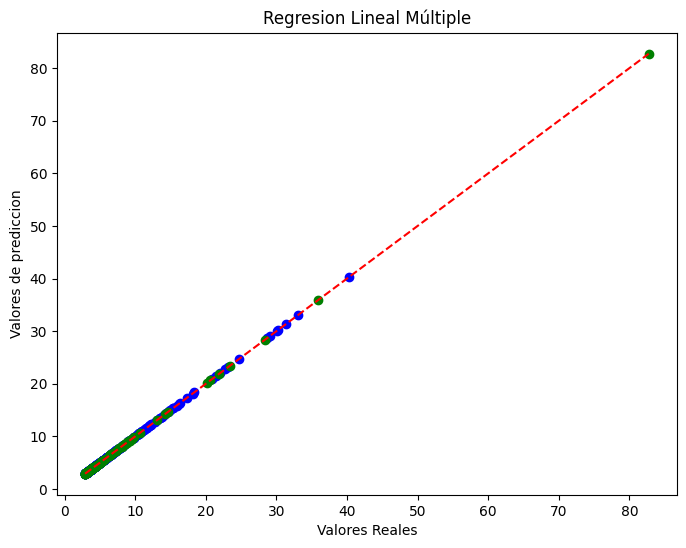

0.999999579509266


In [28]:
modelo = LinearRegression() ## APLICAR MODELO DE REGRESION LINEAL
modelo.fit(vIndependienteEntrenamientoScalado, vDep_entrenamiento)

predicciones_rlm_entrenamiento = modelo.predict(vIndependienteEntrenamientoScalado) #Prediccion de Regrecion lineal de entrenamiento
predicciones_rlm_prueba = modelo.predict(vIndependientePruebasScalado) #Prediccion de Regrecion lineal de prueba

#Configuracion de las variable en el grafico
plt.figure(figsize=(8,6))
plt.scatter(vDep_entrenamiento, predicciones_rlm_entrenamiento, color='blue')
plt.scatter(vDep_pruebas, predicciones_rlm_prueba, color='green')
#LINEA DE IDENTIDAD
plt.plot(
    [vDepMultiple.min(), vDepMultiple.max()],
    [vDepMultiple.min(), vDepMultiple.max()], 'r--'
)

#Titulos y creacion de grafica
plt.xlabel('Valores Reales')
plt.ylabel('Valores de prediccion')
plt.title('Regresion Lineal Múltiple')
plt.show()

#Evaluación de r2
r2_rlm = r2_score(vDep_pruebas, modelo.predict(vIndependientePruebasScalado))
print(r2_rlm)

In [29]:
#Creación de pendiente y intersección
pendiente = modelo.coef_
interseccion = modelo.intercept_

print(f"Pendiente (m): {pendiente}")
print(f"Pendiente (m): {interseccion}")

Pendiente (m): [2.77513437 1.59505134 1.36252659 0.80693744]
Pendiente (m): 6.126666666666667


In [30]:
#Mean square error & mean absolute error
mse_rlm = mean_squared_error(vDep_pruebas, predicciones_rlm_prueba)
rsem_rlm = np.sqrt(mse_rlm)
mae_rlm = mean_absolute_error(vDep_pruebas, predicciones_rlm_prueba)
print("mean_squared_error: ", mse_rlm)
print("mean_absolute_error: ", mae_rlm)

mean_squared_error:  3.686401552756112e-05
mean_absolute_error:  0.003797156729107556


#### Ridge

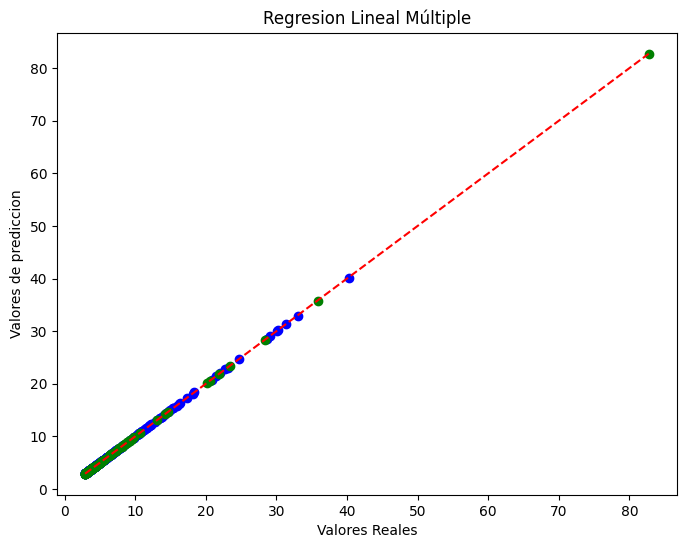

0.999997931651217


In [31]:
modelo_ridge = Ridge(alpha=1.0) #Espesificación del modelo con el alpha 1.0
modelo_ridge.fit(vIndependienteEntrenamientoScalado, vDep_entrenamiento)

predicciones_ridge_entrenamiento = modelo_ridge.predict(vIndependienteEntrenamientoScalado) #Prediccion de Ridge de entrenamiento
predicciones_ridge_prueba = modelo_ridge.predict(vIndependientePruebasScalado) #Prediccion de Ridge de pruebas

#Configuracion de las variable en el grafico
plt.figure(figsize=(8,6))
plt.scatter(vDep_entrenamiento, predicciones_ridge_entrenamiento, color='blue')
plt.scatter(vDep_pruebas, predicciones_ridge_prueba, color='green')
#LINEA DE IDENTIDAD
plt.plot(
    [vDepMultiple.min(), vDepMultiple.max()],
    [vDepMultiple.min(), vDepMultiple.max()], 'r--'
)

#Titulos y creacion de grafica
plt.xlabel('Valores Reales')
plt.ylabel('Valores de prediccion')
plt.title('Regresion Lineal Múltiple')
plt.show()

#Evaluación de r2
r2_rlm = r2_score(vDep_pruebas, modelo_ridge.predict(vIndependientePruebasScalado))
print(r2_rlm)

In [32]:
#Creación de pendiente y intersección
pendiente_ridge = modelo_ridge.coef_
interseccion_ridge = modelo_ridge.intercept_

print(f"Pendiente (m): {pendiente_ridge}")
print(f"Interseccion (m): {interseccion_ridge}")

Pendiente (m): [2.76845171 1.59482639 1.36184731 0.80735407]
Interseccion (m): 6.126666666666667


In [33]:
#Mean square error & mean absolute error
mse_ridge = mean_squared_error(vDep_pruebas, predicciones_ridge_prueba)
rsem_ridge = np.sqrt(mse_ridge)
mae_ridge = mean_absolute_error(vDep_pruebas, predicciones_ridge_prueba)
print("mean_squared_error: ", mse_ridge)
print("Raiz: ", rsem_ridge)
print("mean_absolute_error: ", mae_ridge)

mean_squared_error:  0.00018133013521320584
Raiz:  0.013465887836054697
mean_absolute_error:  0.007601600019651724


#### Lasso

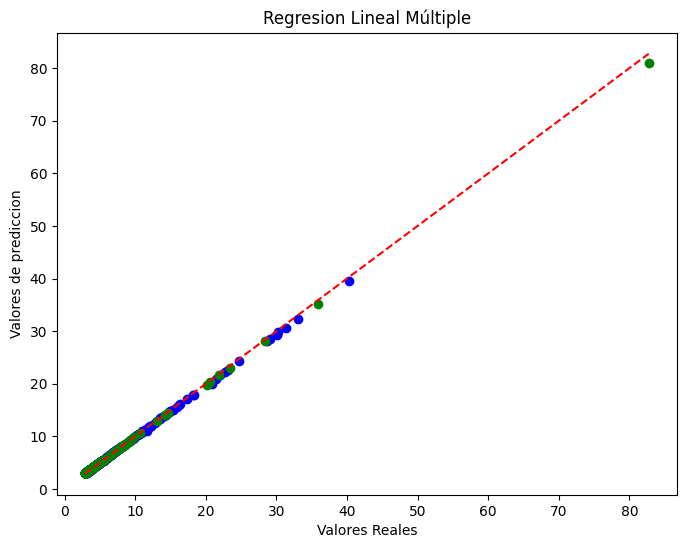

0.9994537114921487


In [34]:
modelo_lasso = Lasso(alpha=0.1) #Espesificación del modelo de 0.1 en decimal
modelo_lasso.fit(vIndependienteEntrenamientoScalado, vDep_entrenamiento)

predicciones_lasso_entrenamiento = modelo_lasso.predict(vIndependienteEntrenamientoScalado) #Prediccion de Lasso de entrenamiento
predicciones_lasso_prueba = modelo_lasso.predict(vIndependientePruebasScalado) #Prediccion de Lasso de prueba

#Configuracion de las variable en el grafico
plt.figure(figsize=(8,6))
plt.scatter(vDep_entrenamiento, predicciones_lasso_entrenamiento, color='blue')
plt.scatter(vDep_pruebas, predicciones_lasso_prueba, color='green')
#LINEA DE IDENTIDAD
plt.plot(
    [vDepMultiple.min(), vDepMultiple.max()],
    [vDepMultiple.min(), vDepMultiple.max()], 'r--'
)

#Titulos y creacion de grafica
plt.xlabel('Valores Reales')
plt.ylabel('Valores de prediccion')
plt.title('Regresion Lineal Múltiple')
plt.show()

#Evaluación de r2
r2_rlm = r2_score(vDep_pruebas, modelo_lasso.predict(vIndependientePruebasScalado))
print(r2_rlm)

In [35]:
#Creación de pendiente y intersección
pendiente_lasso = modelo_lasso.coef_
interseccion_lasso = modelo_lasso.intercept_

print(f"Pendiente (m): {pendiente_lasso}")
print(f"Intersección (m): {interseccion_lasso}")

Pendiente (m): [2.74525478 1.56798289 1.28809853 0.73400564]
Intersección (m): 6.126666666666667


In [36]:
#Mean square error & mean absolute error
mse_lasso = mean_squared_error(vDep_pruebas, predicciones_lasso_prueba)
rsem_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(vDep_pruebas, predicciones_lasso_prueba)
print("mean_squared_error: ", mse_lasso)
print("Raiz: ", rsem_lasso)
print("mean_absolute_error: ", mae_lasso)

mean_squared_error:  0.04789258456133078
Raiz:  0.21884374462463116
mean_absolute_error:  0.10649977256914077


#### ElasticNet

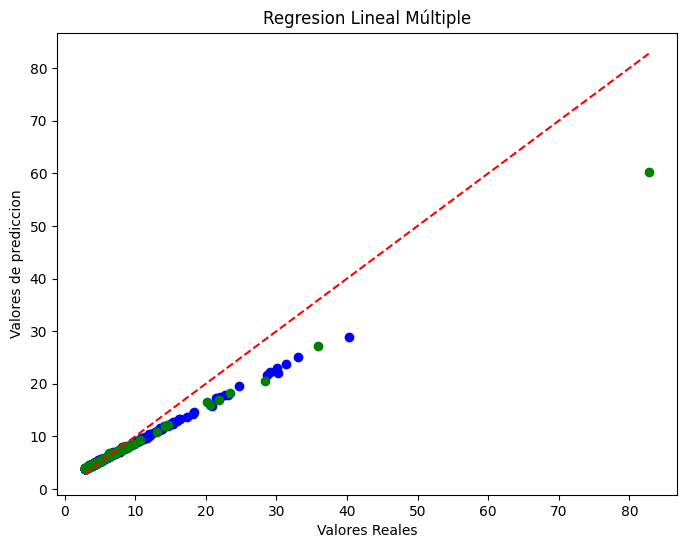

0.9095771849674212


In [37]:
modelo_elastic = ElasticNet(alpha=1.0,l1_ratio=0.5) #Espesificación del modelo de 50 y 50 entre ridge y lasso
modelo_elastic.fit(vIndependienteEntrenamientoScalado, vDep_entrenamiento)

predicciones_elasticNet_entrenamiento = modelo_elastic.predict(vIndependienteEntrenamientoScalado) #Prediccion de elasticNet de entrenamiento
predicciones_elasticNet_prueba = modelo_elastic.predict(vIndependientePruebasScalado) #Prediccion de elasticNet de pruebas

#Configuracion de las variable en el grafico
plt.figure(figsize=(8,6))
plt.scatter(vDep_entrenamiento, predicciones_elasticNet_entrenamiento, color='blue')
plt.scatter(vDep_pruebas, predicciones_elasticNet_prueba, color='green')
#LINEA DE IDENTIDAD
plt.plot(
    [vDepMultiple.min(), vDepMultiple.max()],
    [vDepMultiple.min(), vDepMultiple.max()], 'r--'
)

#Titulos y creacion de grafica
plt.xlabel('Valores Reales')
plt.ylabel('Valores de prediccion')
plt.title('Regresion Lineal Múltiple')
plt.show()

#Evaluación de r2
r2_rlm = r2_score(vDep_pruebas, modelo_elastic.predict(vIndependientePruebasScalado))
print(r2_rlm)

In [38]:
#Creación de pendiente y intersección
pendiente_elastic = modelo_elastic.coef_
interseccion_elastic = modelo_elastic.intercept_

print(f"Pendiente (m): {pendiente_elastic}")
print(f"Interseccion (m): {interseccion_elastic}")

Pendiente (m): [1.82273427 1.25999909 0.9145072  0.54079301]
Interseccion (m): 6.126666666666667


In [39]:
#Mean square error & mean absolute error
mse_elastic = mean_squared_error(vDep_pruebas, predicciones_elasticNet_prueba)
rsem_elastic = np.sqrt(mse_elastic)
mae_elastic = mean_absolute_error(vDep_pruebas, predicciones_elasticNet_prueba)
print("mean_squared_error: ", mse_elastic)
print("Raiz: ", rsem_elastic)
print("mean_absolute_error: ", mae_elastic)

mean_squared_error:  7.927280645632433
Raiz:  2.8155426911400996
mean_absolute_error:  1.2370479560023677


#### Conclusión 3er parcial
Agregando de que si utilizamos un modelo simple de regresión es más eficaz cuando tenemos menos datos para poder hacer nuestras predicciones. Puede funcionar, pero si queremos hacer la evaluación de cada variable de ventas de videojuegos. Pero a la vez no puede funcionar si queremos contemplar varios datos porque tendríamos que hacerlo uno por uno.

Pero si se diera un caso como en el proyecto donde se utilizan varios datos para ser más preciso. En este caso es más eficaz para el caso de ventas por países ya que contemplamos varios países para nuestra variable dependiente de ventas globales.

Y gracias al análisis de datos podemos decir que la mejor solución para la multicoleanidad es Ridge, ya que obtenemos una multicolinealidad que respeta propuesta por la original de la regresión lineal múltiple. Además de que necesitamos todas las variables seleccionadas para poder sacar nuestra variable dependiente que son las ventas globales. En este caso solo necesitamos bajar sus coeficientes para poder tener más precisión con nuestros datos.

Además, hay que tomar en cuenta las variables de error que en Ridge son las más bajas compitiendo con las del modelo de lasso, teniendo un mejor ajuste con nuestras predicciones del modelo ridge, dándonos por consecuente predicciones más pequeñas en promedio.

Siendo la más desequilibrada la de ElasticNet.
